In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

In [2]:
pip -q install fbprophet

Note: you may need to restart the kernel to use updated packages.


In [3]:
pd.plotting.register_matplotlib_converters()
%matplotlib inline

print("Setup Complete")

Setup Complete


In [4]:
stock_df = pd.read_csv("stocks.csv")
stock_df.set_index('date')
stock_df['date'] = pd.to_datetime(stock_df['date'])

In [5]:
import datetime
last_date = stock_df.tail(1)["date"].iloc[0]
forecast_start = last_date + datetime.timedelta(days=1)
last_date, forecast_start

(Timestamp('2018-02-07 00:00:00'), Timestamp('2018-02-08 00:00:00'))

In [6]:
pip -q install --upgrade plotly

Note: you may need to restart the kernel to use updated packages.


In [7]:
from fbprophet import Prophet

In [8]:
stock_df['AAPL'] = pd.to_numeric(stock_df['AAPL'])
stock_df['YUM'] = pd.to_numeric(stock_df['YUM'])
stock_df['ABC'] = pd.to_numeric(stock_df['ABC'])
stock_df['ADI'] = pd.to_numeric(stock_df['ADI'])
print(stock_df.dtypes)

date    datetime64[ns]
AAPL           float64
YUM            float64
ABC            float64
ADI            float64
dtype: object


In [9]:
df = stock_df[['AAPL', 'date']]

In [10]:
holidays = pd.DataFrame(
    [
        ["2017-12-25", "Christmas", -7, 7],
        ["2018-12-25", "Christmas", -7, 7],
        ["2019-12-25", "Christmas", -7, 7], 
        ["2017-11-24", "Black Friday", -2, 3],
        ["2018-11-24", "Black Friday", -2, 3],
    ], 
    columns=["ds", "holiday", "lower_window", "upper_window"]
)

In [11]:
stk = df.rename(columns={'date': 'ds', 'AAPL': 'y'})
stk_model = Prophet(
    interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, 
    yearly_seasonality=True, holidays=holidays)
stk_model.fit(stk)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Text(0.5, 1.0, 'AAPL Forecast')

<Figure size 1440x720 with 0 Axes>

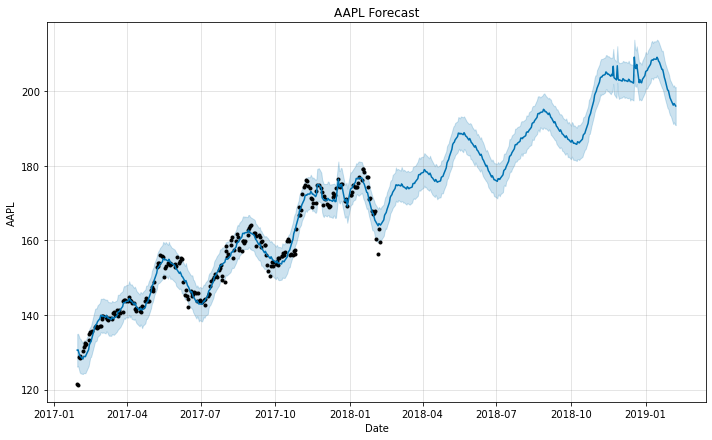

In [12]:
future = stk_model.make_future_dataframe(periods=365, freq='D', include_history=True)
# Remove weekend
future['day'] = future['ds'].dt.weekday
future = future[future['day'] <= 4]

stk_forecast = stk_model.predict(future)

plt.figure(figsize=(20, 10))

stk_model.plot(stk_forecast, xlabel = 'Date', ylabel = 'AAPL')

plt.title('AAPL Forecast')

In [13]:
stk_forecast.to_csv("stk_forecast.csv",index=False, header=True)


In [14]:
stk_forecast.rename(columns={'ds':'Date',  'trend': 'Trend',
                         'yhat':'Prediction', 'yhat_lower':'Prediction Lower',
                         'yhat_upper':'Prediction Upper'}, inplace=True)
stk_forecast.head()

,Date,Trend,Prediction Lower,Prediction Upper,trend_lower,trend_upper,Black Friday,Black Friday_lower,Black Friday_upper,Christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,Prediction
0,2017-01-30,124.326422,126.126071,134.940549,124.326422,124.326422,0.0,0.0,0.0,0.0,...,0.268064,0.268064,0.268064,-5.167610,-5.167610,-5.167610,0.0,0.0,0.0,130.594128
1,2017-01-31,124.435769,126.354580,134.974747,124.435769,124.435769,0.0,0.0,0.0,0.0,...,0.931129,0.931129,0.931129,-5.893880,-5.893880,-5.893880,0.0,0.0,0.0,130.640270
2,2017-02-01,124.545115,125.556629,134.382053,124.545115,124.545115,0.0,0.0,0.0,0.0,...,0.719209,0.719209,0.719209,-6.542556,-6.542556,-6.542556,0.0,0.0,0.0,129.889020
3,2017-02-02,124.654462,124.639012,133.721092,124.654462,124.654462,0.0,0.0,0.0,0.0,...,0.376593,0.376593,0.376593,-7.103504,-7.103504,-7.103504,0.0,0.0,0.0,129.094803
4,2017-02-03,124.763808,124.360616,133.583835,124.763808,124.763808,0.0,0.0,0.0,0.0,...,0.496818,0.496818,0.496818,-7.568350,-7.568350,-7.568350,0.0,0.0,0.0,128.859528


In [15]:
aapl_df = pd.read_csv("AAPL.csv")
aapl_df.set_index('Date')
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-30,30.232500,30.407499,30.165001,30.407499,28.798475,121510000
1,2017-01-31,30.287500,30.347500,30.155001,30.337500,28.732176,196804000
2,2017-02-01,31.757500,32.622501,31.752501,32.187500,30.484282,447940000
3,2017-02-02,31.995001,32.347500,31.945000,32.132500,30.432201,134841600
4,2017-02-03,32.077499,32.297501,32.040001,32.270000,30.562422,98029200


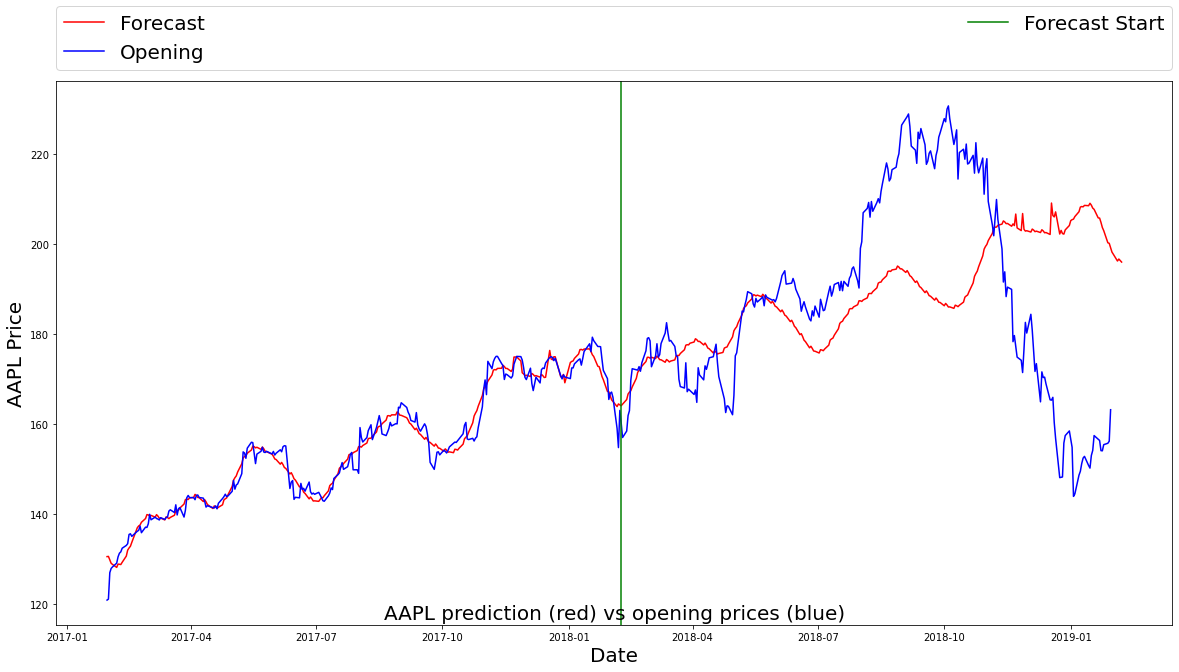

In [16]:
plt.figure(figsize=(20,10))
plt.plot(stk_forecast["Date"], stk_forecast["Prediction"], color="red", label="Forecast")
# Multiply historical prices by 4 to adjust for the stock split
plt.plot(aapl_df["Date"], aapl_df["Open"] * 4, color="blue", label="Opening")

plt.title("AAPL prediction (red) vs opening prices (blue)", y=0, fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('AAPL Price', fontsize=20)
plt.axvline(x=forecast_start, color='green', label = "Forecast Start")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)